# ML from scratch: Stable Diffusion, Day 2

### [Binxu Wang](https://scholar.harvard.edu/binxuw) and [John Vastola](https://twitter.com/johnjvastola)

<p align="center">
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/astro.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/ballerina_chasing_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/lovely_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/turtle3.png?raw=true" alt="drawing" width="150"/>
</p>

On the first day, we went over the various components necessary to make an effective diffusion generative model like [Stable Diffusion](https://ommer-lab.com/research/latent-diffusion-models/).

As a reminder, they are:

- Method of learning to generate new stuff (forward/reverse diffusion)
- Way to link text and images (text-image representation model like [CLIP](https://github.com/openai/CLIP))
- Way to compress images (autoencoder)
- Way to add in good inductive biases (U-net architecture + self/cross-attention)

In today's session, you will implement pieces of each of the above, and by the end have a working Stable-Diffusion-like model.

In particular, you will implement parts of:

- **basic 1D forward/reverse diffusion**
- **a U-Net architecture for working with images**
- **the loss associated with learning the score function**
- **an attention model for conditional generation**
- **an autoencoder**

We need a reasonably small dataset so that training does not take forever, so we will be working with [MNIST](https://en.wikipedia.org/wiki/MNIST_database), a set of 28x28 images of handwritten 0-9 digits. By the end, our model should be able to take in a number prompt (e.g. "4") and output an image of the digit 4.

----------------

In [2]:
!pip install einops
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.8 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid


-------------------------------------------

## 5. Latent space diffusion using an autoencoder

Finally, we get to one of the most important contributions of [Rombach et al.](https://ommer-lab.com/research/latent-diffusion-models/), the paper behind Stable Diffusion! Instead of diffusing in pixel space (i.e. corrupting and denoising each pixel of an image), we can try diffusing in some kind of *latent space*.

This has a few advantages. An obvious one is speed: compressing images before doing forward/reverse diffusion on them makes both generation and training faster. Another advantage is that the latent space, if carefully chosen, may be a more natural or interpretable space for working with images. For example, given a set of pictures of heads, perhaps some latent direction corresponds to head direction.

If we do not have any a priori bias towards one latent space or another, we can just throw an autoencoder at the problem and hope it comes up with something appropriate.

In this section, **we will use an autoencoder to compress MNIST images to a smaller scale**, and glue this to the rest of our diffusion pipeline.

### Defining the autoencoder

**Complete the missing part of the autoencoder's forward function**. Note that what an autoencoder does is first 'encode' an image into some latent representation, and then 'decode' an image from that latent representation.

*Hint: You can access the encoder and decoder via `self.encoder` and `self.decoder`.*

In [4]:
class AutoEncoder(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[4, 8, 32],):
    """Initialize a time-dependent score-based network.
    Args:
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    # Encoding layers where the resolution decreases
    self.encoder = nn.Sequential(nn.Conv2d(1, channels[0], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[0]),
                   nn.SiLU(),
                   nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=True),
                   nn.BatchNorm2d(channels[1]),
                   nn.SiLU(),
                   nn.Conv2d(channels[1], channels[2], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[2]),
                   ) #nn.SiLU(),
    self.decoder = nn.Sequential(nn.ConvTranspose2d(channels[2], channels[1], 3, stride=1, bias=True),
                   nn.BatchNorm2d(channels[1]),
                   nn.SiLU(),
                   nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=True, output_padding=1),
                   nn.BatchNorm2d(channels[0]),
                   nn.SiLU(),
                   nn.ConvTranspose2d(channels[0], 1, 3, stride=1, bias=True),
                   nn.Sigmoid(),)

  def forward(self, x):
    ########## YOUR CODE HERE (1 line)
    output = self.decoder(self.encoder(x))
    ###################
    return output

The following code checks to see whether your autoencoder was defined properly.

In [5]:
x_tmp = torch.randn(1,1,28,28)
print(AutoEncoder()(x_tmp).shape)
assert AutoEncoder()(x_tmp).shape == x_tmp.shape, "Check conv layer spec! the autoencoder input output shape not align"

torch.Size([1, 1, 28, 28])


### Train the autoencoder with the help of a perceptual loss

Let's train the autoencoder on MNIST images! Do this by running the cells below.

The loss could be really small ~ close to 0.01

In [6]:
from lpips import LPIPS

In [7]:
# Define the loss function, MSE and LPIPS
lpips = LPIPS(net="squeeze").cuda()
loss_fn_ae = lambda x,xhat: \
    nn.functional.mse_loss(x, xhat) + \
    lpips(x.repeat(1,3,1,1), x_hat.repeat(1,3,1,1)).mean()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]


100%|██████████| 4.73M/4.73M [00:00<00:00, 36.7MB/s]
/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/squeeze.pth


In [8]:
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ae_model = AutoEncoder([4, 4, 4]).cuda()
n_epochs =   50  #@param {'type':'integer'}
## size of a mini-batch
batch_size =  2048   #@param {'type':'integer'}
## learning rate
lr=10e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

optimizer = Adam(ae_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)
    z = ae_model.encoder(x)
    x_hat = ae_model.decoder(z)
    loss = loss_fn_ae(x, x_hat) #loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  print('{} Average Loss: {:5f}'.format(epoch, avg_loss / num_items))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(ae_model.state_dict(), 'ckpt_ae.pth')

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15155242.89it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 461481.62it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3659716.87it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5008025.44it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/50 [00:00<?, ?it/s]

0 Average Loss: 0.522989
1 Average Loss: 0.302794
2 Average Loss: 0.208902
3 Average Loss: 0.161541
4 Average Loss: 0.129891
5 Average Loss: 0.106193
6 Average Loss: 0.088532
7 Average Loss: 0.075141
8 Average Loss: 0.064280
9 Average Loss: 0.055261
10 Average Loss: 0.047741
11 Average Loss: 0.041358
12 Average Loss: 0.035847
13 Average Loss: 0.030946
14 Average Loss: 0.026770
15 Average Loss: 0.023466
16 Average Loss: 0.020552
17 Average Loss: 0.018636
18 Average Loss: 0.017338
19 Average Loss: 0.016368
20 Average Loss: 0.015601
21 Average Loss: 0.014962
22 Average Loss: 0.014417
23 Average Loss: 0.013935
24 Average Loss: 0.013505
25 Average Loss: 0.013115
26 Average Loss: 0.012762
27 Average Loss: 0.012436
28 Average Loss: 0.012125
29 Average Loss: 0.011845
30 Average Loss: 0.011581
31 Average Loss: 0.011330
32 Average Loss: 0.011099
33 Average Loss: 0.010879
34 Average Loss: 0.010668
35 Average Loss: 0.010474
36 Average Loss: 0.010287
37 Average Loss: 0.010112
38 Average Loss: 0.009

In [9]:
x_hat.shape

torch.Size([608, 1, 28, 28])

The below cell visualizes the results. The autoencoder's output should look almost identical to the original images.

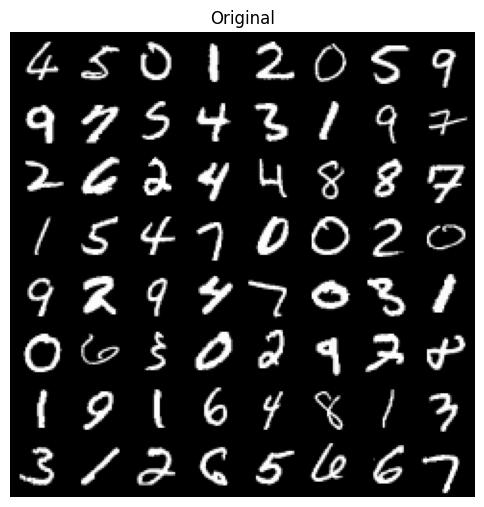

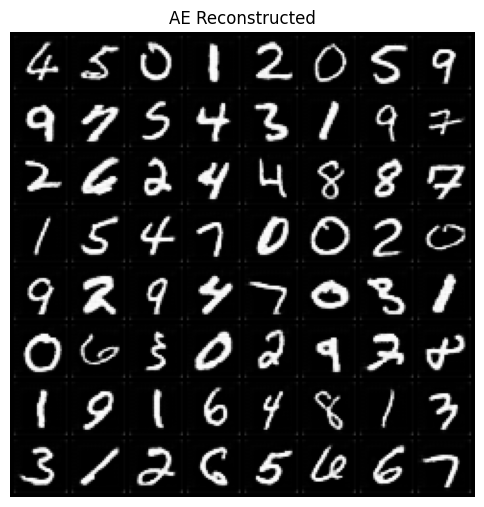

In [10]:
#@title Visualize trained autoencoder
ae_model.eval()
x, y = next(iter(data_loader))
x_hat = ae_model(x.to(device)).cpu()
plt.figure(figsize=(6,6.5))
plt.axis('off')
plt.imshow(make_grid(x[:64,:,:,:].cpu()).permute([1,2,0]), vmin=0., vmax=1.)
plt.title("Original")
plt.show()

plt.figure(figsize=(6,6.5))
plt.axis('off')
plt.imshow(make_grid(x_hat[:64,:,:,:].cpu()).permute([1,2,0]), vmin=0., vmax=1.)
plt.title("AE Reconstructed")
plt.show()

### Create latent state dataset

Let's use our autoencoder to convert MNIST images into a latent space representation. We will use these compressed images to train our diffusion generative model.

In [11]:
batch_size = 4096
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
ae_model.requires_grad_(False)
ae_model.eval()
zs = []
ys = []
for x, y in tqdm(data_loader):
  z = ae_model.encoder(x.to(device)).cpu()
  zs.append(z)
  ys.append(y)

zdata = torch.cat(zs, )
ydata = torch.cat(ys, )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/15 [00:00<?, ?it/s]

In [12]:
print(zdata.shape)
print(ydata.shape)
print(zdata.mean(), zdata.var())

torch.Size([60000, 4, 10, 10])
torch.Size([60000])
tensor(0.1274) tensor(0.9579)


In [13]:
from torch.utils.data import TensorDataset
latent_dataset = TensorDataset(zdata, ydata)

### Transformer UNet model for Latents

Here is a U-Net (that includes self/cross-attention) similar to the one we defined before, but that this time works with compressed images instead of full-size images. You don't need to do anything here except take a look at the architecture.

In [15]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization.
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]
    # this broadcast the 2d tensor to 4d, add the same value across space.


In [18]:
from einops import rearrange
import math

class CrossAttention(nn.Module):
  def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1,):
    """
    Note: For simplicity reason, we just implemented 1-head attention.
    Feel free to implement multi-head attention! with fancy tensor manipulations.
    """
    super(CrossAttention, self).__init__()
    self.hidden_dim = hidden_dim
    self.context_dim = context_dim
    self.embed_dim = embed_dim
    self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
    if context_dim is None:
      self.self_attn = True
      self.key = nn.Linear(hidden_dim, embed_dim, bias=False)     ###########
      self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)  ############
    else:
      self.self_attn = False
      self.key = nn.Linear(context_dim, embed_dim, bias=False)   #############
      self.value = nn.Linear(context_dim, hidden_dim, bias=False) ############


  def forward(self, tokens, context=None):
    # tokens: with shape [batch, sequence_len, hidden_dim]
    # context: with shape [batch, contex_seq_len, context_dim]
    if self.self_attn:
        Q = self.query(tokens)
        K = self.key(tokens)
        V = self.value(tokens)
    else:
        # implement Q, K, V for the Cross attention
        Q = self.query(tokens)
        K = self.key(context)
        V = self.value(context)
    ####### YOUR CODE HERE (2 lines)
    print(Q.shape, K.shape, V.shape)
    scoremats = torch.einsum("BTH,BSH->BTS", Q, K) # inner product of Q and K, a tensor
    attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1) # softmax of scoremats
    print(scoremats.shape, attnmats.shape, )
    ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # weighted average value vectors by attnmats
    return ctx_vecs


class TransformerBlock(nn.Module):
  """The transformer block that combines self-attn, cross-attn and feed forward neural net"""
  def __init__(self, hidden_dim, context_dim):
    super(TransformerBlock, self).__init__()
    self.attn_self = CrossAttention(hidden_dim, hidden_dim, )
    self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

    self.norm1 = nn.LayerNorm(hidden_dim)
    self.norm2 = nn.LayerNorm(hidden_dim)
    self.norm3 = nn.LayerNorm(hidden_dim)
    # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
    self.ffn  = nn.Sequential(
        # YOUR CODE HERE ##################
        nn.Linear(hidden_dim, 3*hidden_dim),
        nn.GELU(),
        nn.Linear(3*hidden_dim, hidden_dim)
    )

  def forward(self, x, context=None):
    # Notice the + x as residue connections
    x = self.attn_self(self.norm1(x)) + x
    # Notice the + x as residue connections
    x = self.attn_cross(self.norm2(x), context=context) + x
    # Notice the + x as residue connections
    x = self.ffn(self.norm3(x)) + x
    return x

class SpatialTransformer(nn.Module):
  def __init__(self, hidden_dim, context_dim):
    super(SpatialTransformer, self).__init__()
    self.transformer = TransformerBlock(hidden_dim, context_dim)

  def forward(self, x, context=None):
    b, c, h, w = x.shape
    x_in = x
    # Combine the spatial dimensions and move the channel dimen to the end
    x = rearrange(x, "b c h w->b (h w) c")
    # Apply the sequence transformer
    x = self.transformer(x, context)
    # Reverse the process
    x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
    # Residue
    return x + x_in

In [19]:
class Latent_UNet_Tranformer(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[4, 64, 128, 256], embed_dim=256,
               text_dim=256, nClass=10):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(channels[0], channels[1], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[1])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[1])
    self.conv2 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[2])
    self.gnorm2 = nn.GroupNorm(4, num_channels=channels[2])
    self.attn2 = SpatialTransformer(channels[2], text_dim)
    self.conv3 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[3])
    self.gnorm3 = nn.GroupNorm(4, num_channels=channels[3])
    self.attn3 = SpatialTransformer(channels[3], text_dim)

    self.tconv3 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False, )
    self.dense6 = Dense(embed_dim, channels[2])
    self.tgnorm3 = nn.GroupNorm(4, num_channels=channels[2])
    self.attn6 = SpatialTransformer(channels[2], text_dim)
    self.tconv2 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     # + channels[2]
    self.dense7 = Dense(embed_dim, channels[1])
    self.tgnorm2 = nn.GroupNorm(4, num_channels=channels[1])
    self.tconv1 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=1) # + channels[1]

    # The swish activation function
    self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    self.cond_embed = nn.Embedding(nClass, text_dim)

  def forward(self, x, t, y=None):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.time_embed(t))
    y_embed = self.cond_embed(y).unsqueeze(1)
    # Encoding path
    ## Incorporate information from t
    h1 = self.conv1(x) + self.dense1(embed)
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h2 = self.attn2(h2, y_embed)
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h3 = self.attn3(h3, y_embed)

    # Decoding path
    ## Skip connection from the encoding path
    h = self.tconv3(h3) + self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.attn6(h, y_embed)
    h = self.tconv2(h + h2)
    h += self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

### Training our latent diffusion model

Finally, we will put everything together, and combine our latent space representation with our fancy U-Net for learning the score function. (This may not actually work that well...but at least you can appreciate that, with all these moving parts, this becomes a hard engineering problem.)

Run the cell below to train our latent diffusion model!

In [20]:
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [22]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t, y=y)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [24]:
#@title Training Latent diffusion model

continue_training = False #@param {type:"boolean"}
if not continue_training:
  print("initilize new score model...")
  latent_score_model = torch.nn.DataParallel(
      Latent_UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn,
                  channels=[4, 16, 32, 64], ))
  latent_score_model = latent_score_model.to(device)


n_epochs =   250 #@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

latent_data_loader = DataLoader(latent_dataset, batch_size=batch_size, shuffle=True, )
latent_score_model.train()
optimizer = Adam(latent_score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.5, 0.995 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for z, y in latent_data_loader:
    z = z.to(device)
    loss = loss_fn_cond(latent_score_model, z, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * z.shape[0]
    num_items += z.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(latent_score_model.state_dict(), 'ckpt_latent_diff_transformer.pth')

initilize new score model...


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-20-d5a11e0a7c34>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
torch.Size([1024, 9, 32]) torch.Size([1024, 9, 32]) torch.Size([1024, 9, 32])
torch.Size([1024, 9, 9]) torch.Size([1024, 9, 9])
torch.Size([1024, 9, 32]) torch.Size([1024, 1, 32]) torch.Size([1024, 1, 32])
torch.Size([1024, 9, 1]) torch.Size([1024, 9, 1])
torch.Size([1024, 1, 64]) torch.Size([1024, 1, 64]) torch.Size([1024, 1, 64])
torch.Size([1024, 1, 1]) torch.Size([1024, 1, 1])
torch.Size([1024, 1, 64]) torch.Size([1024, 1, 64]) torch.Size([1024, 1, 64])
torch.Size([1024, 1, 1]) torch.Size([1024, 1, 1])
torch.Size([1024, 9, 32]) torch.Size([1024, 9, 32]) torch.Size([1024, 9, 32])
torch.Size([1024, 9, 9]) torch.Size([1024, 9, 9])
torch.Size([1024, 9, 32]) torch.Size([1024, 1, 32]) torch.Size([1024, 1, 32])
torch.Size([1024, 9, 1]) torch.Size([1024, 9, 1])
torch.Size([1024, 9, 32]) torch.Size([1024, 9, 32]) torch.Size([1024, 9, 32])
torch.Size([1024, 9, 9]) torch.Size([1024, 9, 9])
torch.Size([1024, 9, 32]) torch.Size([1024, 1, 

Loss at ~55 after 600 epochs, pretty slow

In [26]:
def Euler_Maruyama_sampler(score_model,
              marginal_prob_std,
              diffusion_coeff,
              batch_size=64,
              x_shape=(1, 28, 28),
              num_steps=500,
              device='cuda',
              eps=1e-3, y=None):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

### Examine Samples

Below, we examine some samples in more detail to study the image generation quality. You may see some pretty weird stuff here.

In [28]:
def visualize_digit_embedding(digit_embed):
  cossim_mat = []
  for i in range(10):
    cossim = torch.cosine_similarity(digit_embed, digit_embed[i:i+1,:]).cpu()
    cossim_mat.append(cossim)
  cossim_mat = torch.stack(cossim_mat)
  cossim_mat_nodiag = cossim_mat + torch.diag_embed(torch.nan * torch.ones(10))
  plt.imshow(cossim_mat_nodiag)
  plt.show()
  return cossim_mat

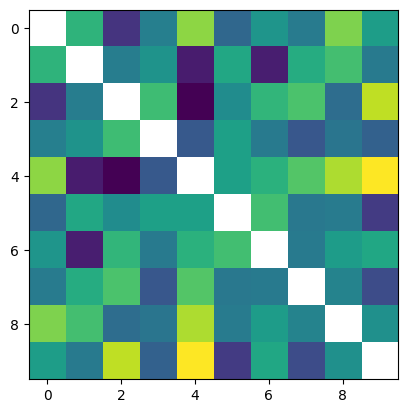

In [29]:
cossim_mat = visualize_digit_embedding(latent_score_model.module.cond_embed.weight.data)

In [36]:
def save_samples_latents(latent_score_model, digit, num_steps):
    sample_batch_size = 64 #@param {'type':'integer'}
    num_steps = 250 #@param {'type':'integer'}
    sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
    latent_score_model.eval()
    ## Generate samples using the specified sampler.
    samples_z = sampler(latent_score_model,
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            sample_batch_size,
            num_steps=num_steps,
            device=device,
            x_shape=(4,10,10),
            y=digit*torch.ones(sample_batch_size, dtype=torch.long))

    ## Sample visualization.
    decoder_samples = ae_model.decoder(samples_z).clamp(0.0, 1.0)
    sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))
    sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
    plt.imsave(f"latent_diffusion_digit%d.png"%digit, sample_np,)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_np, vmin=0., vmax=1.)
    plt.show()

<ipython-input-37-b74d5f38f2ec>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_score_model.load_state_dict(torch.load("ckpt_latent_diff_transformer.pth"))
<ipython-

  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-20-d5a11e0a7c34>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


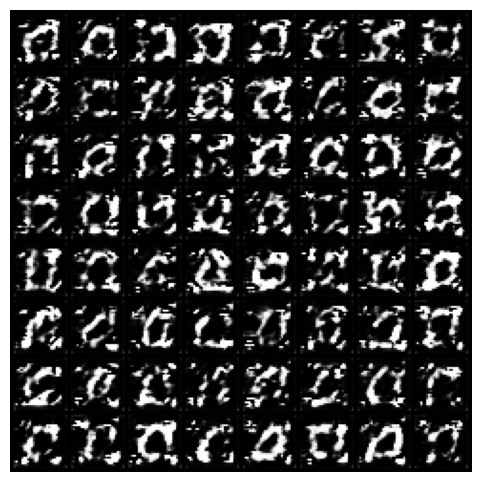

In [37]:
latent_score_model = torch.nn.DataParallel(Latent_UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn, channels=[4, 16, 32, 64], ))
latent_score_model.load_state_dict(torch.load("ckpt_latent_diff_transformer.pth"))
save_samples_latents(latent_score_model, 0, 250)

<ipython-input-20-d5a11e0a7c34>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-20-d5a11e0a7c34>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


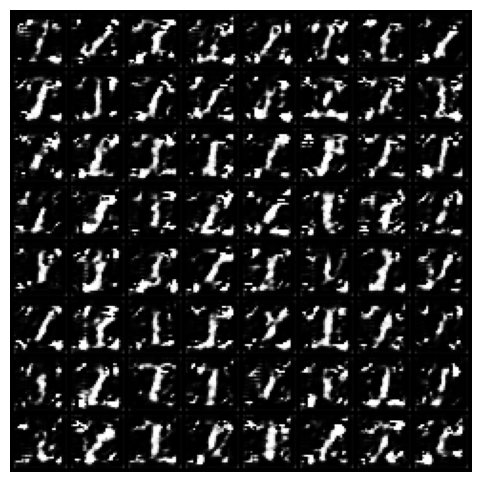

In [38]:
save_samples_latents(latent_score_model, 1, 250)

<ipython-input-20-d5a11e0a7c34>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-20-d5a11e0a7c34>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


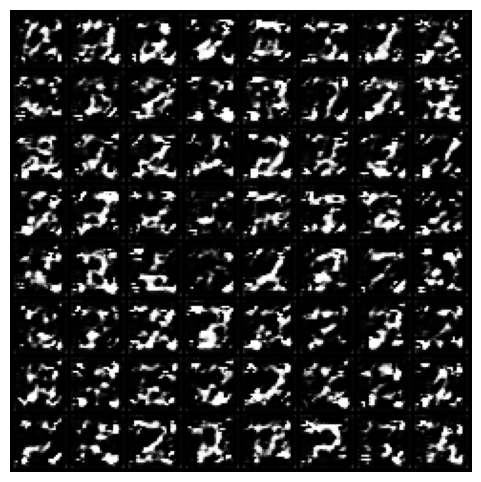

In [39]:
save_samples_latents(latent_score_model, 2, 250)

<ipython-input-20-d5a11e0a7c34>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-20-d5a11e0a7c34>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


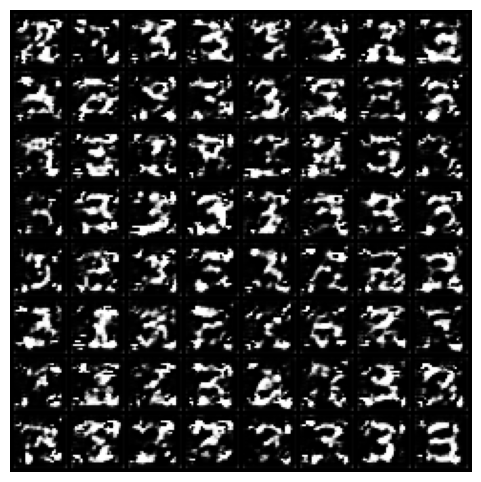

In [40]:
save_samples_latents(latent_score_model, 3, 250)

<ipython-input-20-d5a11e0a7c34>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-20-d5a11e0a7c34>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


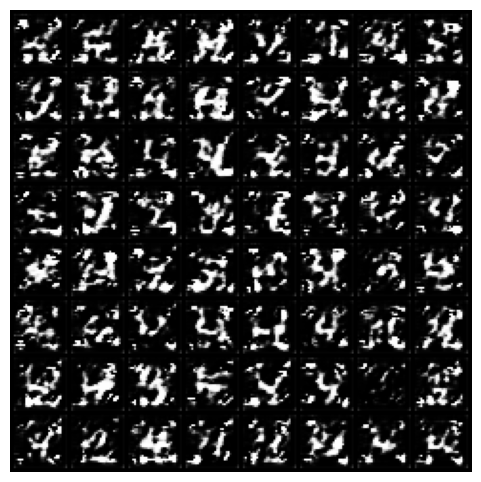

In [41]:
save_samples_latents(latent_score_model, 4, 250)

<ipython-input-20-d5a11e0a7c34>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-20-d5a11e0a7c34>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


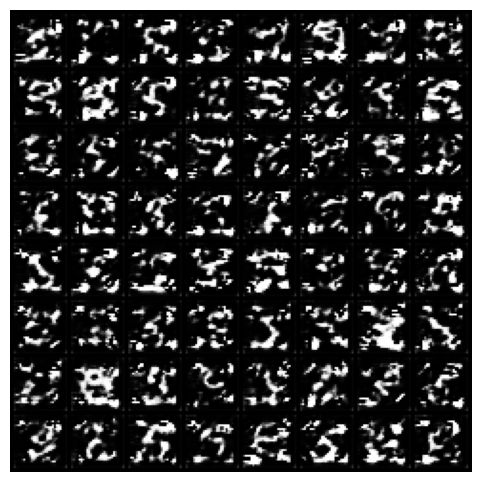

In [42]:
save_samples_latents(latent_score_model, 5, 250)

<ipython-input-20-d5a11e0a7c34>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-20-d5a11e0a7c34>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


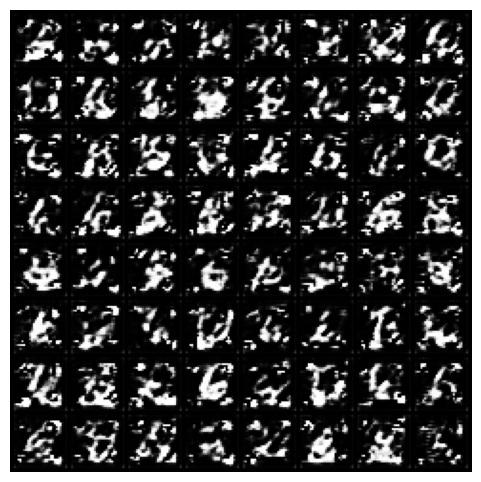

In [43]:
save_samples_latents(latent_score_model, 6, 250)

<ipython-input-20-d5a11e0a7c34>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-20-d5a11e0a7c34>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


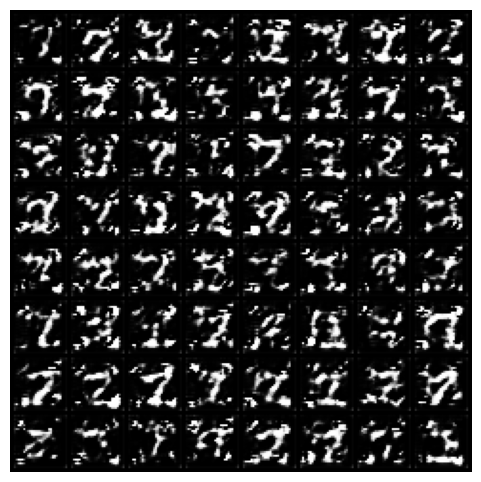

In [44]:
save_samples_latents(latent_score_model, 7, 250)

<ipython-input-20-d5a11e0a7c34>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-20-d5a11e0a7c34>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


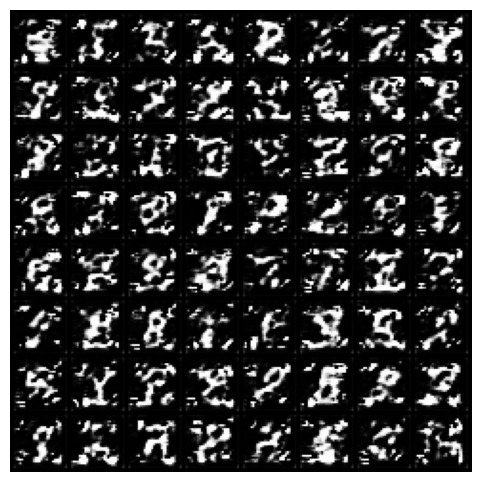

In [45]:
save_samples_latents(latent_score_model, 8, 250)

<ipython-input-20-d5a11e0a7c34>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-20-d5a11e0a7c34>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


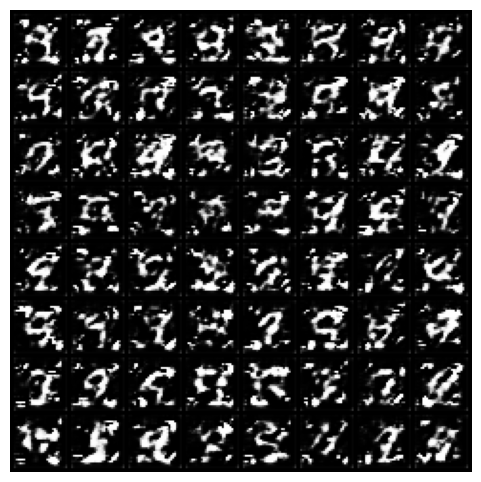

In [46]:
save_samples_latents(latent_score_model, 9, 250)